In [4]:
import os

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

plt.rcParams["figure.figsize"] = 30, 30

In [3]:



data_dir = "/mnt/data/pycodes/Dataset/imagenet2012"
write_dir = "/home/ani/Documents/datasets/imagenet"

download_config = tfds.download.DownloadConfig(
                      extract_dir=os.path.join(write_dir, 'extracted'),
                      manual_dir=data_dir
                  )
download_and_prepare_kwargs = {
    'download_dir': os.path.join(write_dir, 'downloaded'),
    'download_config': download_config,
}


ds, info = tfds.load('imagenet2012', 
               data_dir=os.path.join(write_dir, 'data'),         
               split='train', 
               shuffle_files=False, 
               download=True, 
               as_supervised=True,
               with_info=True,
               download_and_prepare_kwargs=download_and_prepare_kwargs)


Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1281167 [00:00<?, ? examples/s]

Shuffling imagenet2012-train.tfrecord...:   0%|          | 0/1281167 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imagenet2012-validation.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling imagenet2012-test.tfrecord...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset imagenet2012 downloaded and prepared to /home/ani/Documents/datasets/imagenet/data/imagenet2012/5.1.0. Subsequent calls will reuse this data.


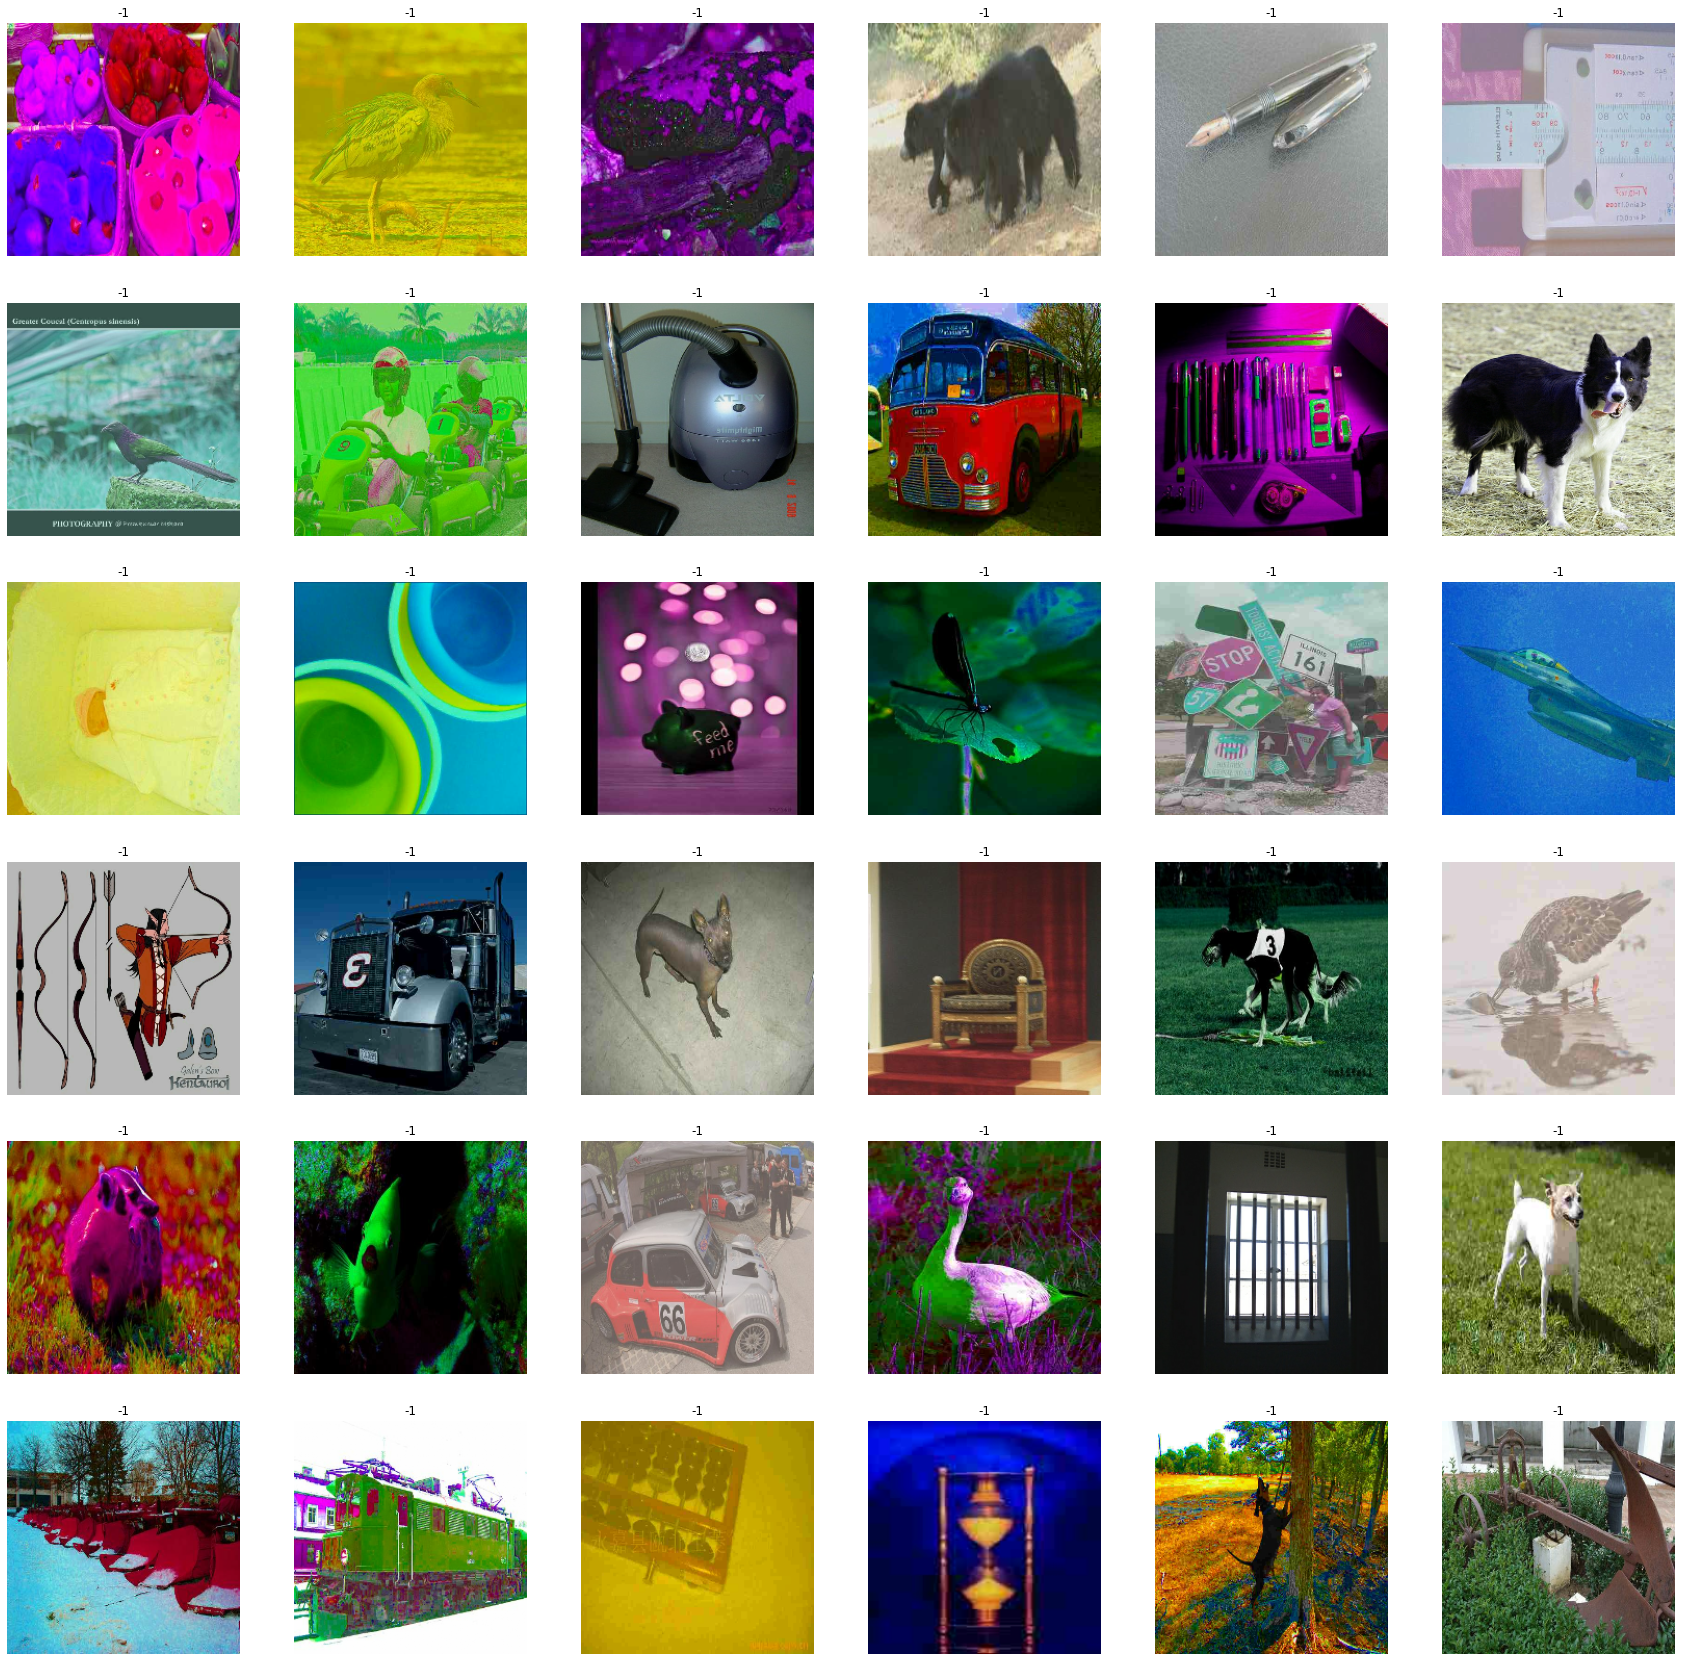

In [17]:
class ImageNetDataLoader:
    def __init__(
        self,
        source_data_dir: str,
        dest_data_dir: str,
        split: str = "train",
        image_dims: tuple = (224, 224),
    ) -> None:
        """
        __init__
        - Instance Variable Initialization
        - Dataset Verification
        - Listing all files in the given path
        Args:
            data_dir (str): Path to the Dataset Directory
            image_dims (tuple, optional): Image Dimensions (width & height). Defaults to (224, 224).
        """

        self.BATCH_SIZE = None
        self.NUM_CHANNELS = 3
        self.LABELS = []
        self.LABELMAP = {}
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE

        self.WIDTH, self.HEIGHT = image_dims    
        
        download_config = tfds.download.DownloadConfig(
            extract_dir=os.path.join(dest_data_dir, 'extracted'),
            manual_dir=source_data_dir
        )
        
        download_and_prepare_kwargs = {
            'download_dir': os.path.join(dest_data_dir, 'downloaded'),
            'download_config': download_config,
        }

        self.dataset, self.info = tfds.load(
            'imagenet2012', 
            data_dir=os.path.join(dest_data_dir, 'data'),         
            split=split, 
            shuffle_files=False, 
            download=True, 
            as_supervised=True,
            with_info=True,
            download_and_prepare_kwargs=download_and_prepare_kwargs
        )
    
    
    def preprocess_image(self, image, label):
        image = tf.cast(image, tf.uint8)
        image = tf.image.resize(image, [self.HEIGHT, self.WIDTH])
        image = image / tf.math.reduce_max(image)
        return image, label
    
    @tf.function
    def augment_batch(self, image, label) -> tuple:
        """
        augment_batch
        Image Augmentation for Training:
        - Random Contrast
        - Random Brightness
        - Random Hue (Color)
        - Random Saturation
        - Random Horizontal Flip
        - Random Reduction in Image Quality
        - Random Crop
        Args:
            image (Tensor Image): Raw Image
            label (Tensor): One-Hot Encoded Label
        Returns:
            tuple: Raw Image, One-Hot Encoded Label
        """
        if tf.random.normal([1]) < 0:
            image = tf.image.random_contrast(image, 0.2, 0.9)
        if tf.random.normal([1]) < 0:
            image = tf.image.random_brightness(image, 0.2)
        if self.NUM_CHANNELS == 3 and tf.random.normal([1]) < 0:
            image = tf.image.random_hue(image, 0.3)
        if self.NUM_CHANNELS == 3 and tf.random.normal([1]) < 0:
            image = tf.image.random_saturation(image, 0, 15)
        
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_jpeg_quality(image, 10, 100)

        return image, label
    
    def get_dataset_size(self) -> int:
        """
        get_dataset_size
        Get the Dataset Size (Number of Images)
        Returns:
            int: Total Number of images in Dataset
        """
        return len(self.dataset)
    
    def get_num_steps(self) -> int:
        """
        get_num_steps
        Get the Number of Steps Required per Batch for Training
        Raises:
            AssertionError: Dataset Generator needs to be Initialized First
        Returns:
            int: Number of Steps Required for Training Per Batch
        """
        if self.BATCH_SIZE is None:
            raise AssertionError(
                f"Batch Size is not Initialized. Call this method only after calling: {self.dataset_generator}"
            )
        num_steps = self.get_dataset_size() // self.BATCH_SIZE + 1
        return num_steps
    
    def dataset_generator(self, batch_size=32, augment=False):
        """
        dataset_generator
        Create the Data Loader Pipeline and Return a Generator to Generate Datsets
        Args:
            batch_size (int, optional): Batch Size. Defaults to 32.
            augment (bool, optional): Enable/Disable Augmentation. Defaults to False.
        Returns:
            Tf.Data Generator: Dataset Generator
        """
        self.BATCH_SIZE = batch_size

        dataset = self.dataset.apply(tf.data.experimental.ignore_errors())

        dataset = dataset.shuffle(batch_size * 10)
        dataset = dataset.repeat()
               
        if augment:
            dataset = dataset.map(self.augment_batch, num_parallel_calls=self.AUTOTUNE)
        
        dataset = dataset.map(self.preprocess_image, num_parallel_calls=self.AUTOTUNE)
        
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=self.AUTOTUNE)

        return dataset
    
    def visualize_batch(self, augment=True) -> None:
        """
        visualize_batch
        Dataset Sample Visualization
        - Supports Augmentation
        - Automatically Adjusts for Grayscale Images
        Args:
            augment (bool, optional): Enable/Disable Augmentation. Defaults to True.
        """
        if self.NUM_CHANNELS == 1:
            cmap = "gray"
        else:
            cmap = "viridis"

        dataset = self.dataset_generator(batch_size=36, augment=augment)
        image_batch, label_batch = next(iter(dataset))
        image_batch, label_batch = (
            image_batch.numpy(),
            label_batch.numpy(),
        )

        for n in range(len(image_batch)):
            ax = plt.subplot(6, 6, n + 1)
            plt.imshow(image_batch[n], cmap=cmap)
            plt.title(label_batch[n])
            plt.axis("off")
        plt.show()
        
data_loader = ImageNetDataLoader(
        source_data_dir = "/mnt/data/pycodes/Dataset/imagenet2012",
        dest_data_dir = "/home/ani/Documents/datasets/imagenet",
        split = "test",
        image_dims = (224, 224),
)

data_loader.visualize_batch(augment=True)